In [1]:
import pandas as pd
import tweepy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import json
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from config import (consumer_key, consumer_secret, 
                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
#Pull into a DataFrame the tweet's source acount, its text, its date, and its compound, 
#positive, neutral, and negative sentiment scores.

# Target User Accounts
target_user = ("@BBCWorld", "@CBSNews", "@CNN", "@FoxNews", "@nytimes")

# List for dictionaries of results
bar_aggrigate_data = {}
csv_data = {}


#lists to hold all the data
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
username = []
tweet_text = []
tweet_time = []
tweets_ago = []

# Loop through each user

for user in target_user:

    oldest_tweet = None
    counter = 0


    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from user home feed
        public_tweets = api.user_timeline(user, page=x, result_type="recent", max_id=oldest_tweet)
        

        # Loop through all tweets
        for tweet in public_tweets:
            
            text = tweet["text"]
            time = tweet["created_at"]
            
            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]

            # Add each value to the appropriate list
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
            username.append(user)
            tweet_text.append(text)
            tweet_time.append(time)
            
            #reassigning the oldest tweet
            tweet_id = tweet["id"]
            oldest_tweet = tweet_id - 1
        
            # Increase counter by 1
            counter += 1


    # Create a dictionaty of results
    tweet_number = np.arange(1,101).tolist()
    tweets_ago = tweets_ago + tweet_number
    user_aggrigate = {user: np.mean(compound_list)}
    csv_results = {"News Organization": username,
                  "Tweet": tweet_text,
                  "Tweet Time": tweet_time,
                  "Compound Score": compound_list,
                  "Positive Score": positive_list,
                  "Neutral Score": neutral_list,
                  "Negative Score": negative_list,
                  "Tweets Ago": tweets_ago}

    # Append dictionary to list
    bar_aggrigate_data.update(user_aggrigate)
    csv_data.update(csv_results)
    
    # Print the Averages
    print(f"User: {user}")
    print(f"Compound: {np.mean(compound_list):.3f}")

User: @BBCWorld
Compound: -0.157
User: @CBSNews
Compound: -0.192
User: @CNN
Compound: -0.152
User: @FoxNews
Compound: -0.133
User: @nytimes
Compound: -0.107


In [4]:
csv_df = pd.DataFrame.from_dict(csv_data)

csv_df.to_csv('tweet_results.csv')

csv_df.head()

,Compound Score,Negative Score,Neutral Score,News Organization,Positive Score,Tweet,Tweet Time,Tweets Ago
0,0.0000,0.000,1.000,@BBCWorld,0.0,North Korea: Runners take part in Pyongyang's ...,Sun Apr 08 16:42:02 +0000 2018,1
1,0.0000,0.000,1.000,@BBCWorld,0.0,RT @BBC_HaveYourSay: Are you coming to Windsor...,Sun Apr 08 15:52:04 +0000 2018,2
2,-0.4767,0.279,0.721,@BBCWorld,0.0,Police foil Berlin half-marathon knife attack ...,Sun Apr 08 15:44:22 +0000 2018,3
3,-0.8074,0.675,0.325,@BBCWorld,0.0,Trump condemns Syria suspected chemical attack...,Sun Apr 08 13:38:00 +0000 2018,4
4,-0.8860,0.634,0.366,@BBCWorld,0.0,Canada crash: Country mourns Humboldt Broncos ...,Sun Apr 08 13:12:29 +0000 2018,5


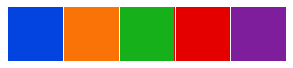

In [5]:
colors = ["blue", "orange", "green","red","purple"]
sns.palplot(sns.xkcd_palette(colors))
news_colors = sns.xkcd_palette(colors)

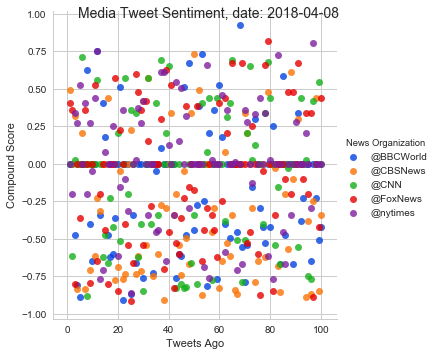

In [11]:
sns.set_style("whitegrid", {'axes.grid' : True})
tweet_results_plot = sns.lmplot(x="Tweets Ago", y="Compound Score", hue='News Organization', 
                                data=csv_df, fit_reg=False, palette=news_colors, scatter_kws={"edgecolor": "black"})

# Accessing the figure to add a title, adding a title 
today = datetime.date.today()
tweet_results_plot.fig.suptitle(f'Media Tweet Sentiment, date: {today}', fontsize=14)
tweet_results_plot.savefig("tweet_scatter.png")

In [7]:
# Creating a Dataframe for the agrigate compound scores
aggrigate_results_df = pd.DataFrame.from_dict(bar_aggrigate_data, orient="index")
aggrigate_results_df.reset_index(level=0, inplace=True)
aggrigate_results_df = aggrigate_results_df.rename(columns={0: "Mean Compound Score", "index": "News Organization"})
aggrigate_results_df.head()

,News Organization,Mean Compound Score
0,@BBCWorld,-0.157101
1,@CBSNews,-0.192032
2,@CNN,-0.152107
3,@FoxNews,-0.132625
4,@nytimes,-0.106581


Text(0.5,1,'Overall Media Sentiment, date: 2018-04-08')

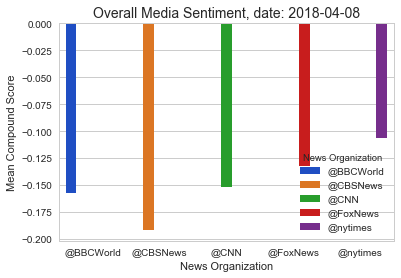

In [8]:
#Bar plot for overall sentiment
bar_plot = sns.barplot(x="News Organization", y="Mean Compound Score", hue="News Organization", 
                       data=aggrigate_results_df, palette=news_colors)

bar_plot.axes.set_title(f'Overall Media Sentiment, date: {today}', fontsize=14)
